## German Traffic Sign Classifier

### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\project\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The device is: {device}")

The device is: cuda


### Defining data transformers and loaders

In [3]:
'''
Input: .png (PIL image) with pixel range [0, 255]
Output: torch.FloatTensor 
'''

train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 15 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
#         transforms.RandomAdjustSharpness(0.3,0.3),
#         transforms.RandomAutocontrast(0.3, 0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], #the mean and std values are chosen upon google search. 
                             [0.229, 0.224, 0.225]) #In pratice other values can also be choosen
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

The data is downloaded from torchvision.datasets

In [4]:
# Create training set and define training and validation dataloader
train_set = datasets.GTSRB(root="/kaggle/working",split='train', transform = train_transform, download=True)

# split the train set into train and validation set
val_data, train_data = torch.utils.data.random_split(train_set, [3640, 23000])

train_loader = torch.utils.data.DataLoader(train_data, batch_size =64, 
                                           shuffle =True, num_workers =2)
val_loader =  torch.utils.data.DataLoader(val_data, batch_size=64,
                                          shuffle=True, num_workers=2)

# Create test set and define test dataloader
test_data = datasets.GTSRB(root="/kaggle/working",split='test', transform = test_transform, download=True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle =True, num_workers =2)

In [5]:
classes = pd.read_csv(r"signnames.csv")
print(classes)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

In [6]:
## Exploring the data
print(f"Training set has: {train_data.__len__()} samples")
print(f"Validation set has: {val_data.__len__()} samples")
print(f"Test set has: {test_data.__len__()} samples")

Training set has: 23000 samples
Validation set has: 3640 samples
Test set has: 12630 samples


### Function Definitions

In [7]:
## Training Functions

def get_accuracy(pred, labels):
    total = 0
    correct = 0 
    labels , pred = labels.cpu() , pred.cpu()
    _,predicted = torch.max(pred , 1)
    total += len(labels.numpy())
    correct += ((predicted == labels).numpy()).sum()
    return correct/total

def validate(model, valoader, criterion):
    val_loss = 0
    val_accuracy = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            accuracy = get_accuracy(outputs, targets)
            val_accuracy += accuracy
        avg_loss = val_loss/(batch_idx+1)
        avg_acc = val_accuracy/(batch_idx+1)
    return avg_loss, avg_acc
    
    
def train_one_epoch(model, trainloader, optimizer, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = get_accuracy(outputs, targets)
        train_accuracy += accuracy
    avg_train_loss = train_loss/(batch_idx+1)
    avg_train_acc = train_accuracy/(batch_idx+1)
    return avg_train_loss, avg_train_acc, model 

def test_accuracy(model, test_loader):
    correct = 0 # number of correct predictions
    total   = 0 # number of samples in test set
    y_label = []
    y_pred =[]
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs.data , 1)
            total += labels.size(0)
            correct += ((predicted.cpu() == labels.cpu()).numpy()).sum()
            y_label.append(labels.detach().cpu().numpy())
            y_pred.append(predicted.detach().cpu().numpy())
    print(f"Accuracy of the network on test set:{100*correct/total:.5}%")
    return y_label, y_pred

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>9}')
    print(f'_________\n{sum(params):>9}{" <- Total trainable parameters"}')
    

In [8]:
## Plot Functions
def plot_accuracy(epochs, acc_train, acc_val, network_name = "default"):
    plt.plot(epochs,acc_train, 'r-',label='Train Accuracy')
    plt.plot(epochs,acc_val, 'g-',label='Val Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f'Train accuracy and validation accuracy -- {network_name}')
    plt.legend();

def plot_loss(epochs, loss_train, loss_val, network_name = "default"):
    plt.plot(epochs, loss_train, 'r-',label='Train Loss')
    plt.plot(epochs, loss_val, 'g-',label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Train loss and validation loss -- {network_name}")
    plt.legend();

### Custom CNN Network

In [9]:
class CustomNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 6, 3, 1)
        self.conv3 = nn.Conv2d(6, 9, 3, 1)
        self.conv4 = nn.Conv2d(9, 12, 3, 1)
        self.fc1 = nn.Linear(53*53*12, 180)
        self.fc2 = nn.Linear(180, 124)
        self.fc3 = nn.Linear(124, 43)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 53*53*12)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    def count_parameters(self):
        params = [p.numel() for p in self.parameters() if p.requires_grad]
        for item in params:
            print(f'{item:>7}')
        print(f'_______\n{sum(params):>7}{" <- Total trainable parameters"}')

In [10]:
torch.manual_seed(101)
custom_model = CustomNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)
custom_model

CustomNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=33708, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=124, bias=True)
  (fc3): Linear(in_features=124, out_features=43, bias=True)
)

In [11]:
custom_model.count_parameters()

    162
      6
    324
      6
    486
      9
    972
     12
6067440
    180
  22320
    124
   5332
     43
_______
6097416 <- Total trainable parameters


### Training

In [12]:
import time
start_time = time.time()

epoch_range = 50
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val   = []
for epoch in range(epoch_range):
    train_loss, train_acc, custom_model = train_one_epoch(custom_model, train_loader,
                                        optimizer, criterion)
    val_loss, val_acc = validate(custom_model, test_loader, criterion)
    
    message = print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

Epoch: 1 Train Loss: 2.0548 Train Acc: 0.3741 Val Loss: 1.3650 Val Acc: 0.5460
None
Epoch: 2 Train Loss: 0.9982 Train Acc: 0.6683 Val Loss: 0.7519 Val Acc: 0.7554
None
Epoch: 3 Train Loss: 0.5504 Train Acc: 0.8200 Val Loss: 0.4478 Val Acc: 0.8556
None
Epoch: 4 Train Loss: 0.3545 Train Acc: 0.8848 Val Loss: 0.3359 Val Acc: 0.8936
None
Epoch: 5 Train Loss: 0.2564 Train Acc: 0.9171 Val Loss: 0.2803 Val Acc: 0.9093
None
Epoch: 6 Train Loss: 0.2090 Train Acc: 0.9322 Val Loss: 0.2832 Val Acc: 0.9082
None
Epoch: 7 Train Loss: 0.1762 Train Acc: 0.9425 Val Loss: 0.2591 Val Acc: 0.9180
None
Epoch: 8 Train Loss: 0.1575 Train Acc: 0.9495 Val Loss: 0.2175 Val Acc: 0.9327
None
Epoch: 9 Train Loss: 0.1333 Train Acc: 0.9571 Val Loss: 0.2015 Val Acc: 0.9354
None
Epoch: 10 Train Loss: 0.1100 Train Acc: 0.9643 Val Loss: 0.1731 Val Acc: 0.9445
None
Epoch: 11 Train Loss: 0.1091 Train Acc: 0.9645 Val Loss: 0.2268 Val Acc: 0.9296
None
Epoch: 12 Train Loss: 0.0929 Train Acc: 0.9702 Val Loss: 0.1939 Val Acc: 0

#### Save the trained model

In [13]:
# torch.save(custom_model.state_dict(), 'CustomImageModel.pt')

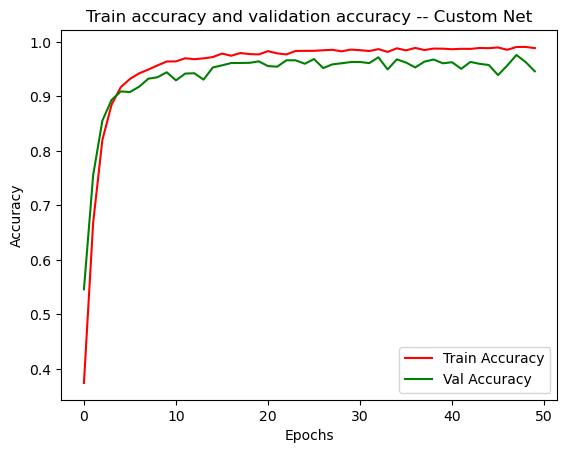

In [14]:
plot_accuracy(epochs, acc_train, acc_val, network_name = "Custom Net")

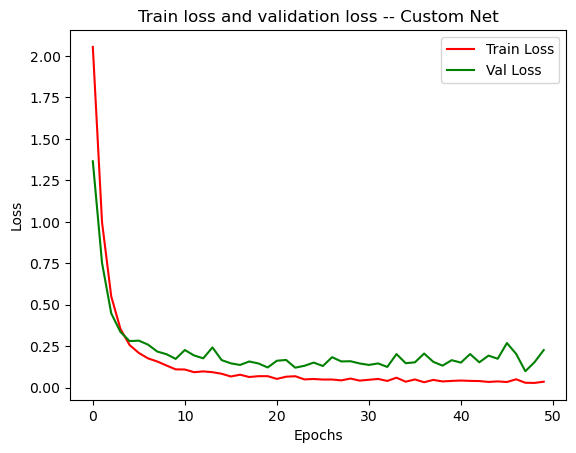

In [15]:
plot_loss(epochs, loss_train, loss_val, network_name = "Custom Net")

In [16]:
y_label, y_pred  = test_accuracy(custom_model, test_loader)

Accuracy of the network on test set:97.9%


### Comparison of custom network with ResNet-18

In [17]:
resnet18 = models.resnet18(pretrained=True)

In [18]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
count_parameters(resnet18)

     9408
       64
       64
    36864
       64
       64
    36864
       64
       64
    36864
       64
       64
    36864
       64
       64
    73728
      128
      128
   147456
      128
      128
     8192
      128
      128
   147456
      128
      128
   147456
      128
      128
   294912
      256
      256
   589824
      256
      256
    32768
      256
      256
   589824
      256
      256
   589824
      256
      256
  1179648
      512
      512
  2359296
      512
      512
   131072
      512
      512
  2359296
      512
      512
  2359296
      512
      512
   512000
     1000
_________
 11689512 <- Total trainable parameters


In [20]:
# modifying the fully connected layer 
fc_in = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_in, 43)

In [21]:
resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-3)

In [22]:
import time
start_time = time.time()

epoch_range = 50
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val   = []
for epoch in range(epoch_range):
    train_loss, train_acc, resnet18 = train_one_epoch(resnet18, train_loader,
                                        optimizer, criterion)
    val_loss, val_acc = validate(resnet18, test_loader, criterion)
    
    message = print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

Epoch: 1 Train Loss: 0.3126 Train Acc: 0.9071 Val Loss: 0.1075 Val Acc: 0.9588
None
Epoch: 2 Train Loss: 0.0677 Train Acc: 0.9781 Val Loss: 0.0731 Val Acc: 0.9804
None
Epoch: 3 Train Loss: 0.0523 Train Acc: 0.9835 Val Loss: 0.0463 Val Acc: 0.9844
None
Epoch: 4 Train Loss: 0.0397 Train Acc: 0.9882 Val Loss: 0.0500 Val Acc: 0.9871
None
Epoch: 5 Train Loss: 0.0308 Train Acc: 0.9905 Val Loss: 0.0178 Val Acc: 0.9945
None
Epoch: 6 Train Loss: 0.0328 Train Acc: 0.9903 Val Loss: 0.0335 Val Acc: 0.9912
None
Epoch: 7 Train Loss: 0.0201 Train Acc: 0.9941 Val Loss: 0.0414 Val Acc: 0.9871
None
Epoch: 8 Train Loss: 0.0287 Train Acc: 0.9926 Val Loss: 0.0318 Val Acc: 0.9912
None
Epoch: 9 Train Loss: 0.0160 Train Acc: 0.9957 Val Loss: 0.0179 Val Acc: 0.9948
None
Epoch: 10 Train Loss: 0.0296 Train Acc: 0.9909 Val Loss: 0.0436 Val Acc: 0.9871
None
Epoch: 11 Train Loss: 0.0226 Train Acc: 0.9932 Val Loss: 0.0347 Val Acc: 0.9877
None
Epoch: 12 Train Loss: 0.0135 Train Acc: 0.9961 Val Loss: 0.0469 Val Acc: 0

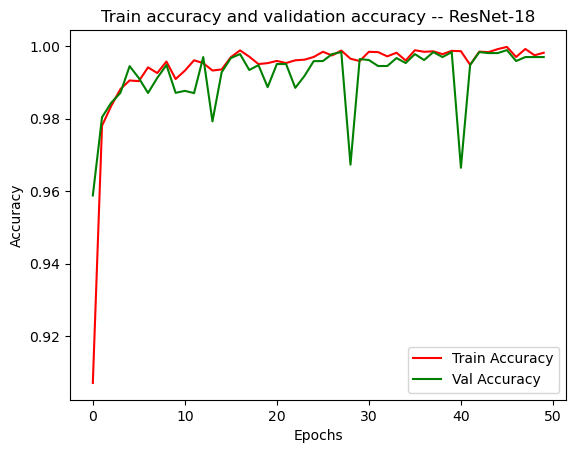

In [23]:
plot_accuracy(epochs, acc_train, acc_val, network_name = "ResNet-18")

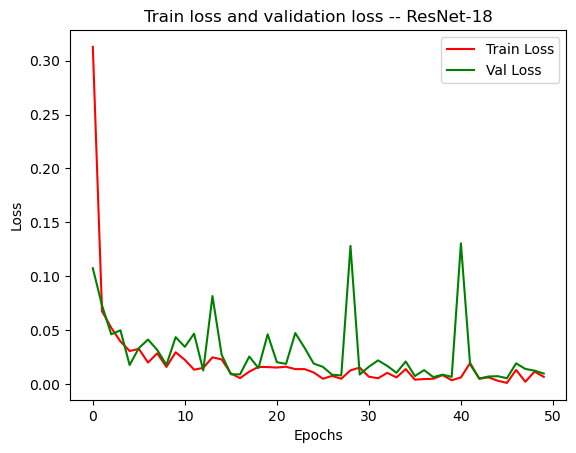

In [24]:
plot_loss(epochs, loss_train, loss_val, network_name = "ResNet-18")

In [25]:
y_label, y_pred = test_accuracy(resnet18, test_loader)

Accuracy of the network on test set:99.926%


### Transfer Learning Method 2: Train ResNet-18 network by freezing ConvNet weights and train only FC layer

The goal is to use one of the larger models which is pretrained on ImageNet database.

The ImageNet database has 1000 categories. As GTSRB contains only 43 categories, I will freeze all the layers except the final layer and train the model with 43 neurons in the final layer.

In [26]:
# importing resnet18 from torchvision with pretrained weights
resnet18_pretrained = models.resnet18(pretrained=True)

In [27]:
# freezing weights in all the layers
for param in resnet18_pretrained.parameters():
    param.requires_grad = False

# modifying the fully connected layer 
fc_in = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(fc_in, 43)

In [28]:
resnet18_pretrained = resnet18_pretrained.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_pretrained.fc.parameters(), lr=1e-3)

In [29]:
import time
start_time = time.time()

epoch_range = 50
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val   = []
for epoch in range(epoch_range):
    train_loss, train_acc, resnet18_pretrained = train_one_epoch(resnet18_pretrained, train_loader,
                                        optimizer, criterion)
    val_loss, val_acc = validate(resnet18_pretrained, test_loader, criterion)
    
    message = print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

Epoch: 1 Train Loss: 1.9133 Train Acc: 0.4998 Val Loss: 1.2453 Val Acc: 0.6726
None
Epoch: 2 Train Loss: 1.1300 Train Acc: 0.6823 Val Loss: 0.9789 Val Acc: 0.7198
None
Epoch: 3 Train Loss: 0.9176 Train Acc: 0.7372 Val Loss: 0.8527 Val Acc: 0.7545
None
Epoch: 4 Train Loss: 0.8098 Train Acc: 0.7633 Val Loss: 0.7693 Val Acc: 0.7647
None
Epoch: 5 Train Loss: 0.7482 Train Acc: 0.7728 Val Loss: 0.7258 Val Acc: 0.7810
None
Epoch: 6 Train Loss: 0.6932 Train Acc: 0.7898 Val Loss: 0.6858 Val Acc: 0.7905
None
Epoch: 7 Train Loss: 0.6619 Train Acc: 0.7962 Val Loss: 0.6292 Val Acc: 0.8079
None
Epoch: 8 Train Loss: 0.6347 Train Acc: 0.8034 Val Loss: 0.6348 Val Acc: 0.8008
None
Epoch: 9 Train Loss: 0.6101 Train Acc: 0.8079 Val Loss: 0.6247 Val Acc: 0.8017
None
Epoch: 10 Train Loss: 0.5873 Train Acc: 0.8150 Val Loss: 0.5675 Val Acc: 0.8223
None
Epoch: 11 Train Loss: 0.5700 Train Acc: 0.8179 Val Loss: 0.5611 Val Acc: 0.8203
None
Epoch: 12 Train Loss: 0.5669 Train Acc: 0.8194 Val Loss: 0.5547 Val Acc: 0

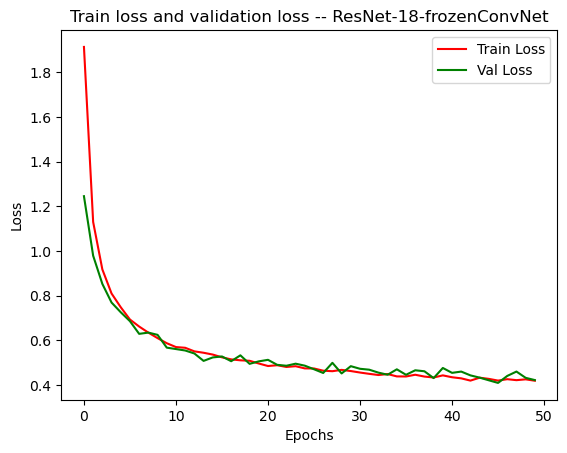

In [32]:
plot_loss(epochs, loss_train, loss_val, network_name = "ResNet-18-frozenConvNet")

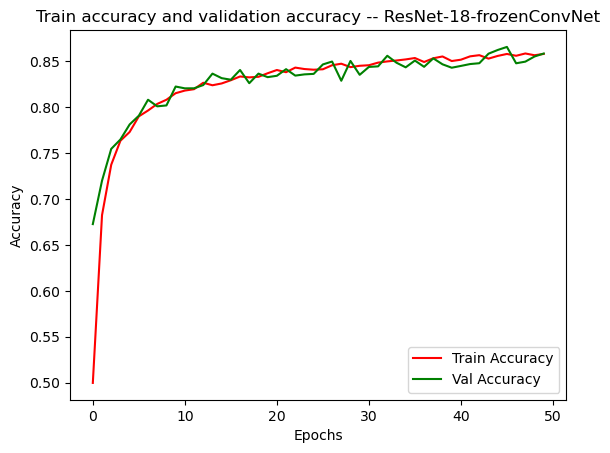

In [33]:
plot_accuracy(epochs, acc_train, acc_val, network_name = "ResNet-18-frozenConvNet")

In [30]:
## Evaluation on test set

y_label, y_pred = test_accuracy(resnet18_pretrained, test_loader)

Accuracy of the network on test set:87.652%


### Testing Custom Model with Images from internet

Predicted value: 2
Predicted class: Speed limit (50km/h)


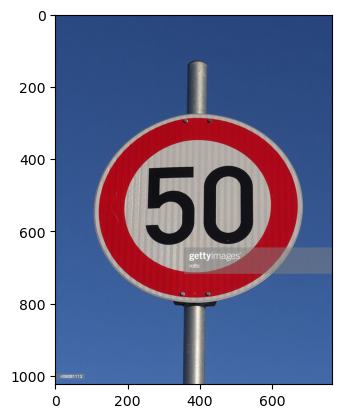

In [31]:
import requests
from PIL import Image
url = 'https://media.gettyimages.com/photos/german-traffic-signs-picture-id459381113'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

# CNN Model Prediction:
test_img = test_transform(img)
custom_model.to('cpu')
custom_model.eval()
with torch.no_grad():
    new_pred = custom_model(test_img).argmax().item()
print(f'Predicted value: {new_pred}')
prediction = classes['SignName'][new_pred]
print(f'Predicted class: {prediction}')    